In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anatools.data as data
import anatools.analysis as ana

import btaggingeffmaps as btef

ana.start()

# Read datasets grouped files and merge DY datasets

In [2]:
period = '17'
basedir = '/dust/btaggingEffMaps'
datasets = data.read_files(basedir, period)

DY = [
    datasets["DYJetsToLL_Pt-Inclusive"],
]

datasets["DYJetsToLL"] = pd.concat(DY).reset_index(drop=True)

for dtname in list(datasets.keys()):
    if dtname.startswith('DYJetsToLL_'):
        del datasets[dtname]

100%|██████████| 32/32 [00:04<00:00,  7.37it/s]


# Check number of events in each dataset after cut in pt

* We can define pt_max for efficiency map sweeping if for all datasets analyzed the number of events after pt_max cut is lesser than 0.1%

In [3]:
pt_max = 1000.
stop_search = False

while stop_search is False:

    above_thr = False
    for dataset_name in datasets.keys():
        df_alljets = datasets.get(dataset_name).reset_index(drop=True)
        n_total = df_alljets.evtWeight.sum()
        n_above_cut = df_alljets[df_alljets.Jet_pt > pt_max].evtWeight.sum()
        quant = n_above_cut/n_total
        if quant > 0.001:
            above_thr = True
            quant = "{:.1f}%".format(100*quant)
            print(dataset_name, '->', quant)

    if above_thr:
        pt_max += 10
    else:
        stop_search = True

print(f'Chosen pt_max = {pt_max}')

Chosen pt_max = 1000.0


# Compute efficiency maps for all datasets

In [4]:
if os.path.isdir("../output") is False:
    os.mkdir("../output")

def makeBtaggingEffMaps(meta):

    dataset_name = meta.get('dataset_name')
    max_unc = meta.get('max_unc')
    eta_bins = meta.get('eta_bins')
    year = meta.get('year')
    apv = meta.get('apv')
    algo = meta.get('algo')
    working_point = meta.get('working_point')
    pt_min = meta.get('pt_min')
    pt_max = meta.get('pt_max')
    step_size = meta.get('step_size')
    unc_stop = meta.get('unc_stop')
    unc_increase = meta.get('unc_increase')
    find_best_unc = meta.get('find_best_unc')

    df = datasets.get(dataset_name).reset_index(drop=True)
    mmap = btef.BTaggingEfficiencyMap(df, eta_bins)
    mmap.calib(year, apv, algo, working_point)
    eff_map = mmap.make(pt_min, pt_max, step_size, max_unc, find_best_unc, unc_stop, unc_increase)

    return (dataset_name, eff_map)

year = '2017'
apv = False
algo = 'DeepCSV'
working_point = 'loose'
eta_bins = [0., 0.6, 1.2, 2.4]
pt_min = 20.
step_size = 5.
unc_stop = 0.3
unc_increase = 0.0002

uncmap_fpath = f'../output/btaguncmap-{algo}-{working_point}-{year}-{apv}.json'
if os.path.exists(uncmap_fpath) is False:
    accepted_unc = {
        dataset_name: {
            "b": 0.001,
            "c": 0.001,
            "udsg": 0.001
        }
        for dataset_name in datasets.keys()
    }
else:
    with open(uncmap_fpath, 'r') as f:
        accepted_unc = json.load(f)

job_metadata = []

for dataset_name in datasets.keys():
    job_metadata.append({
        'dataset_name': dataset_name,
        'max_unc': accepted_unc.get(dataset_name),
        'eta_bins': eta_bins,
        'year': year,
        'apv': apv,
        'algo': algo,
        'working_point': working_point,
        'pt_min': pt_min,
        'pt_max': pt_max,
        'step_size': step_size,
        'unc_stop': unc_stop,
        'unc_increase': unc_increase,
        'find_best_unc': True
    })

results = [makeBtaggingEffMaps(meta) for meta in job_metadata]

eff_maps = dict([(res[0], res[1][0]) for res in results])
unc_maps = dict([(res[0], res[1][1]) for res in results])

json_fname = f'btageffmap-{algo}-{working_point}-{year}-{apv}.json'
json_fpath = os.path.join('../output', json_fname)
with open(json_fpath, 'w') as f:
    json.dump(eff_maps, f)

json_fname = f'btaguncmap-{algo}-{working_point}-{year}-{apv}.json'
json_fpath = os.path.join('../output', json_fname)
with open(json_fpath, 'w') as f:
    json.dump(unc_maps, f, indent=4, ensure_ascii=False)

/workspace/btaggingeffmaps/__init__.py:79: RuntimeWarning: invalid value encountered in true_divide
  unc = np.sqrt(hist_tag2) / hist_tag


# Efficiency per eta bin

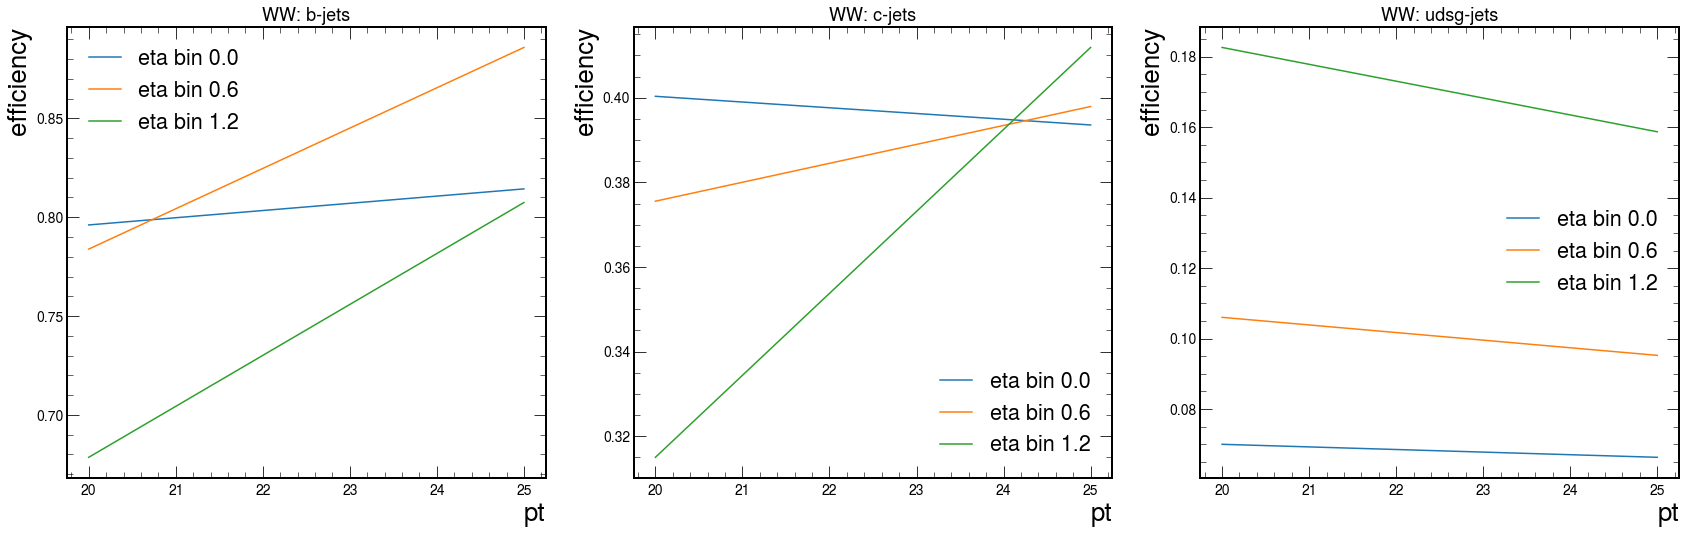

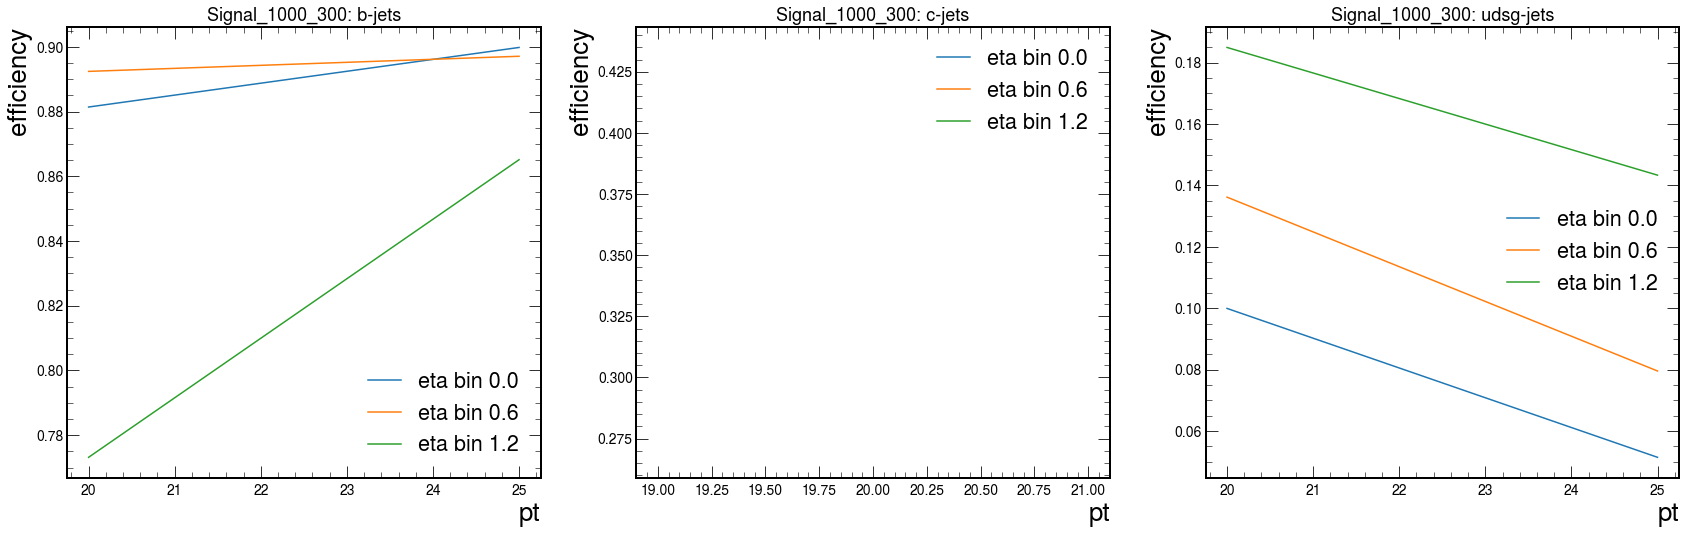

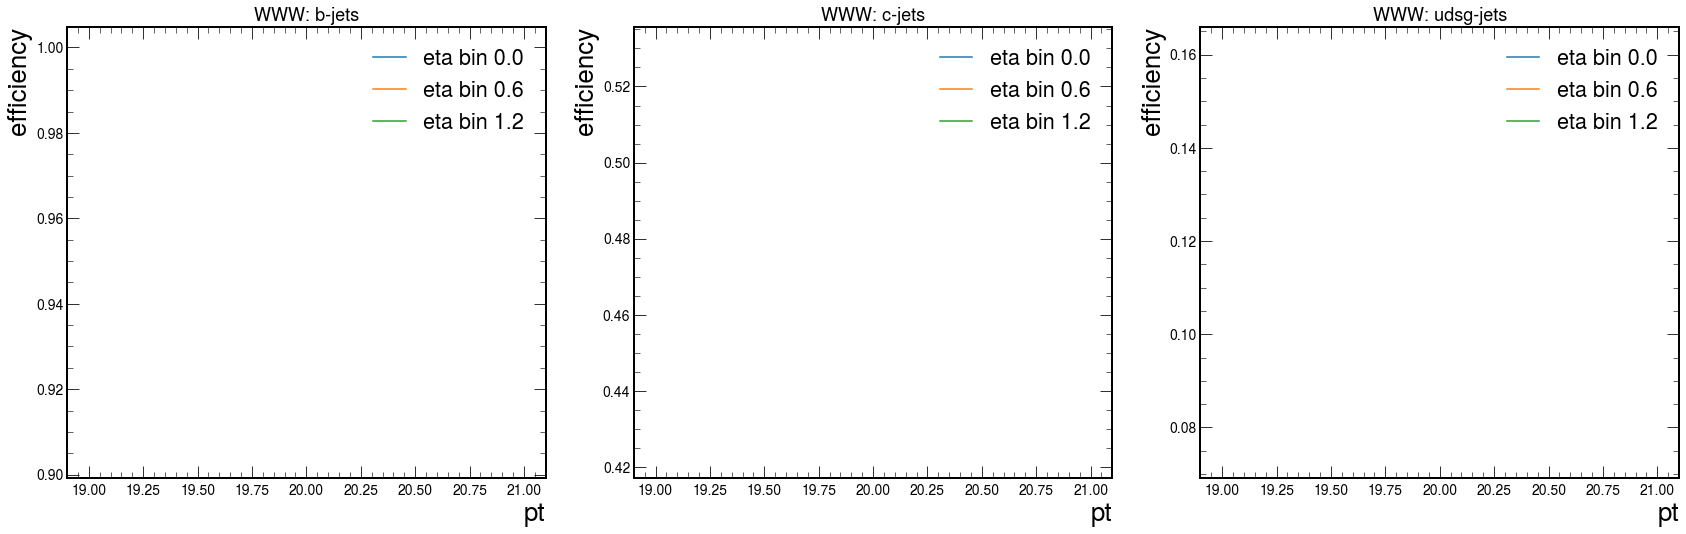

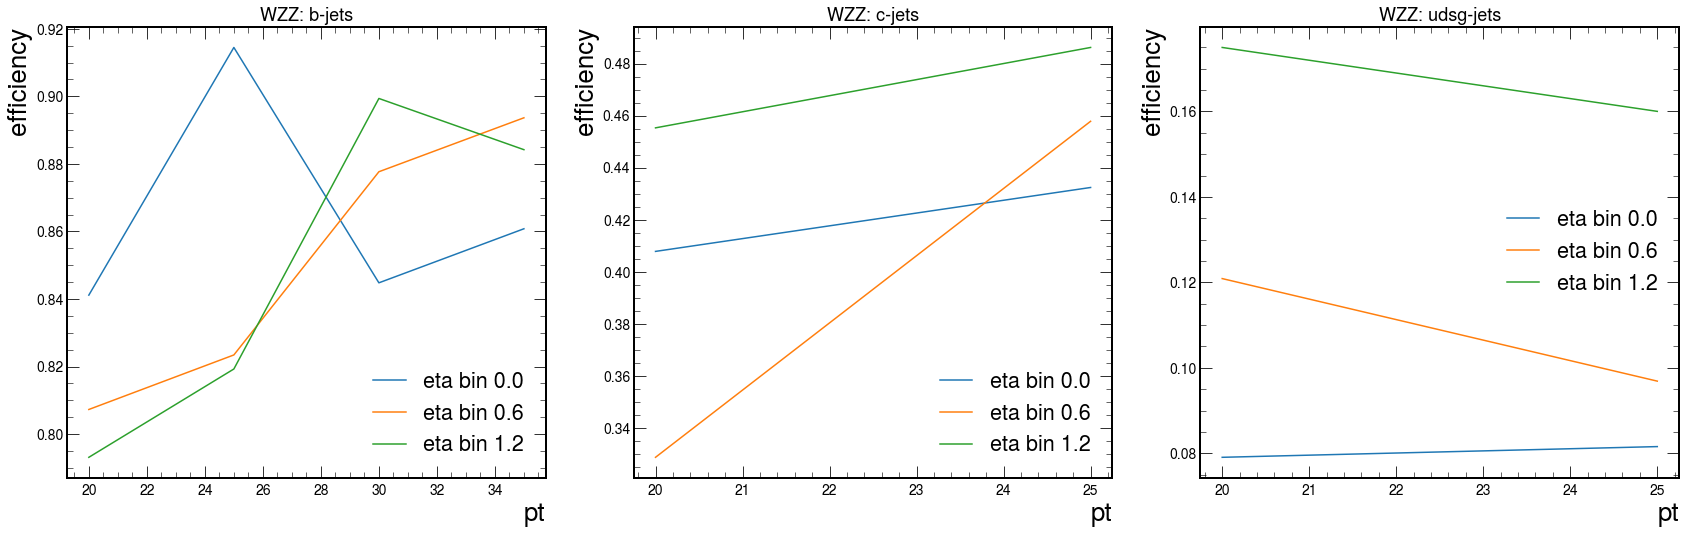

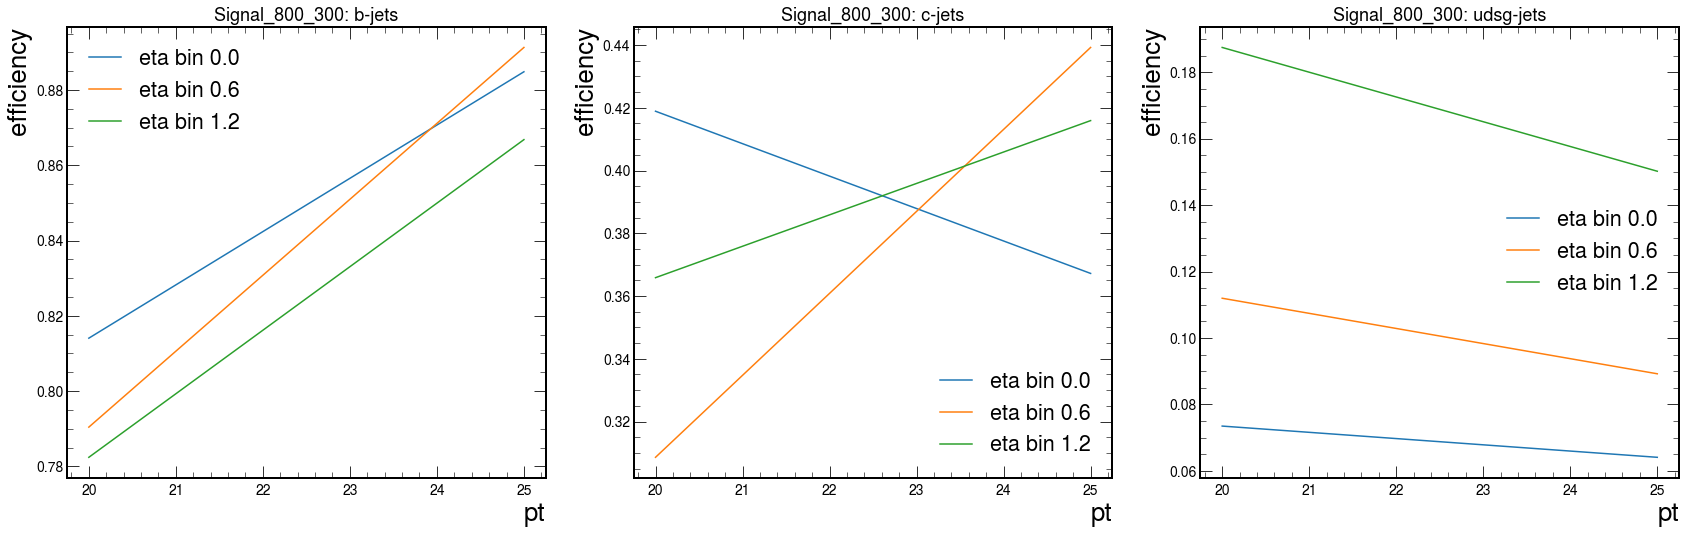

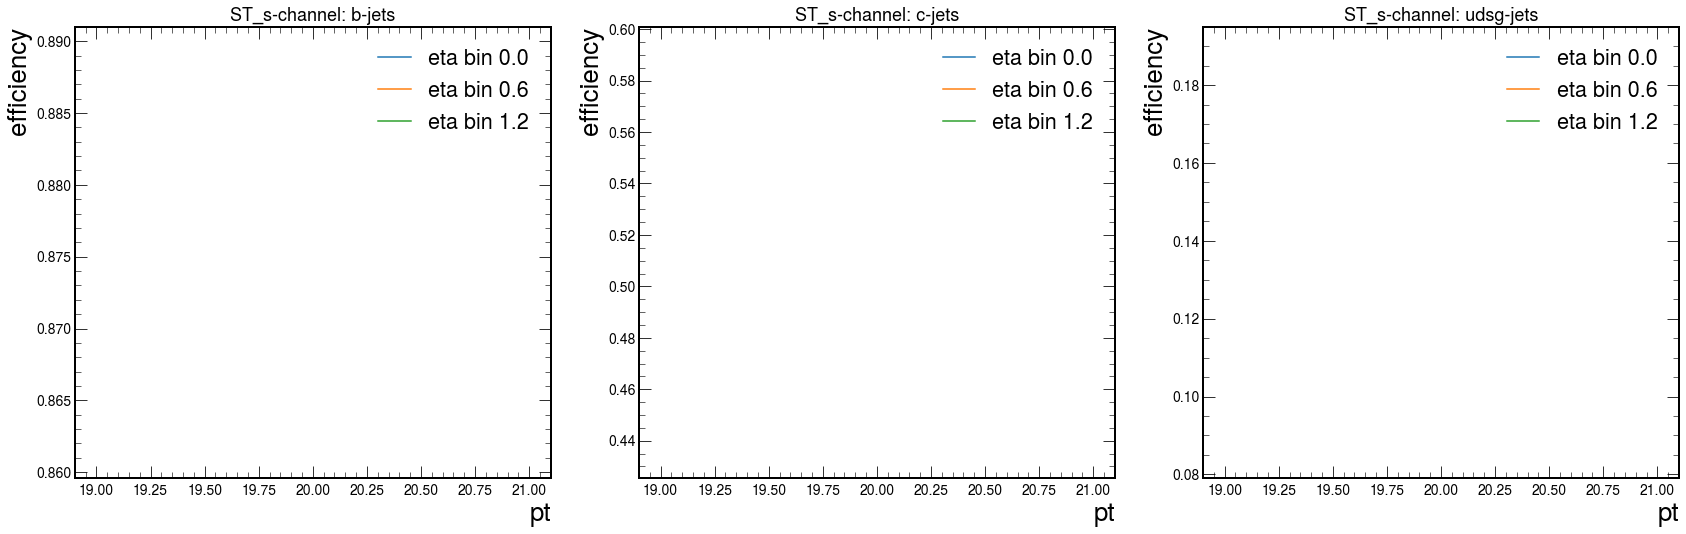

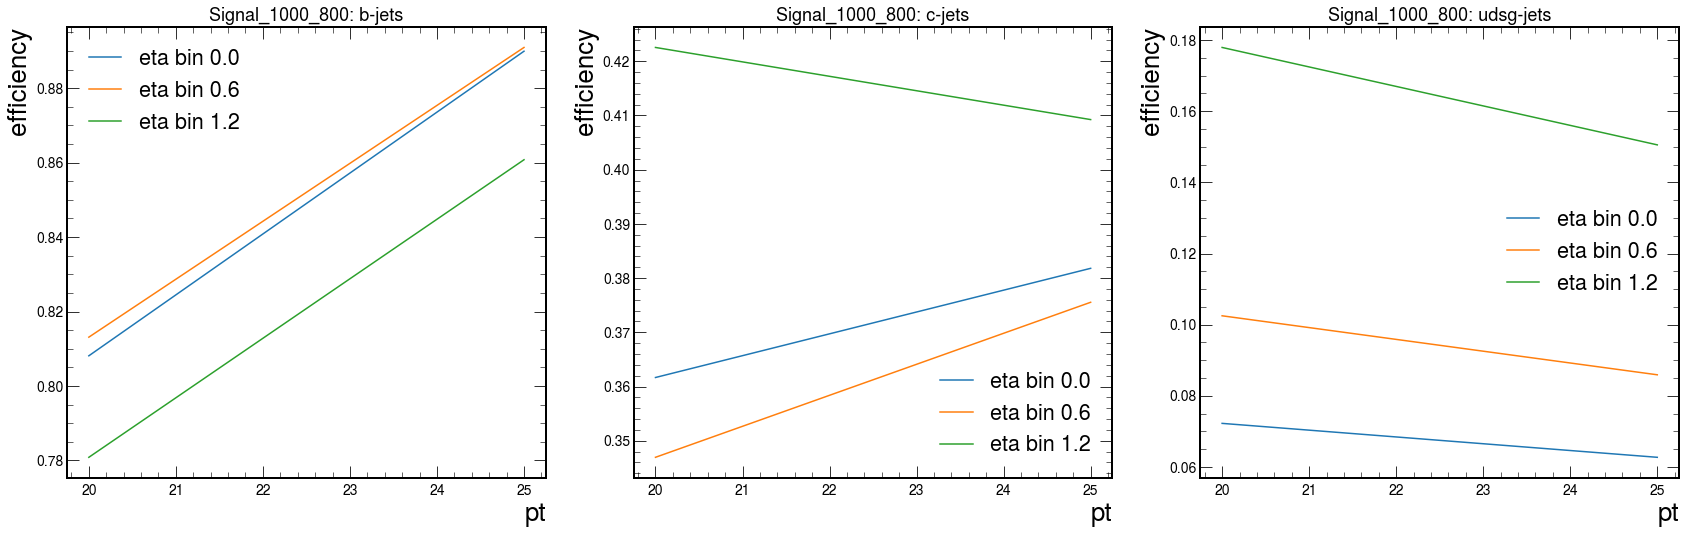

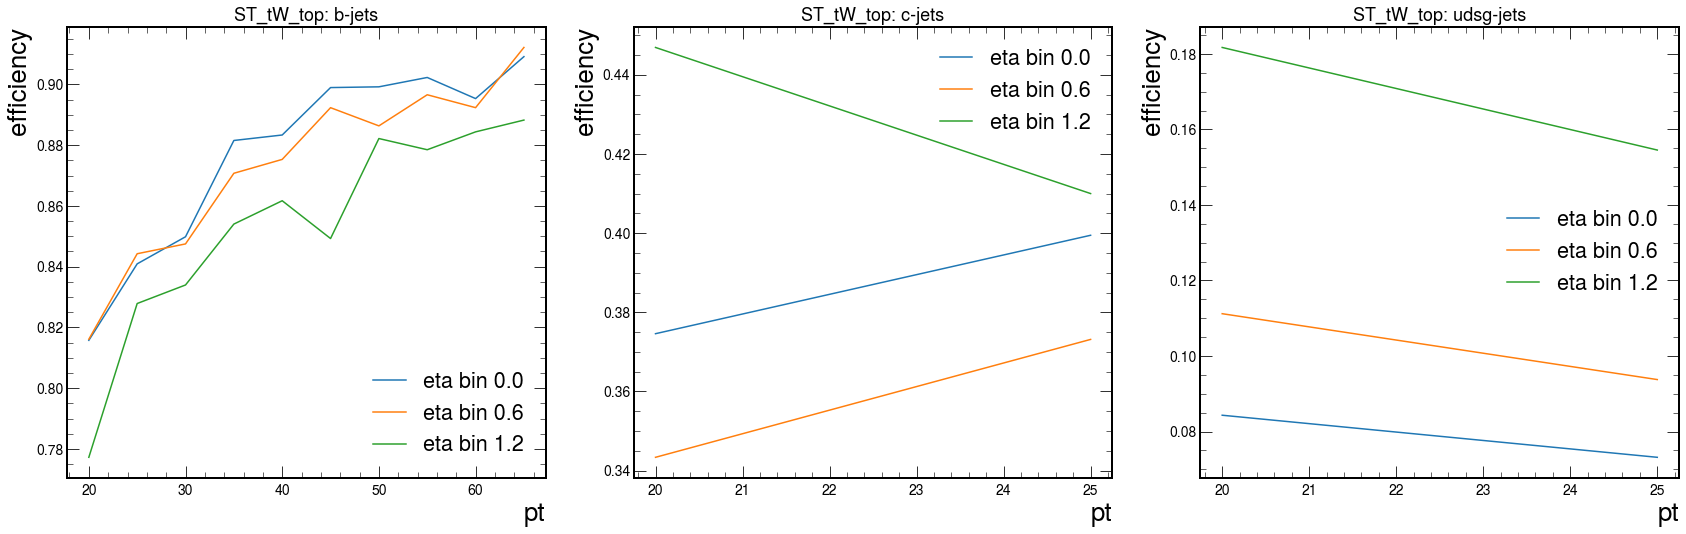

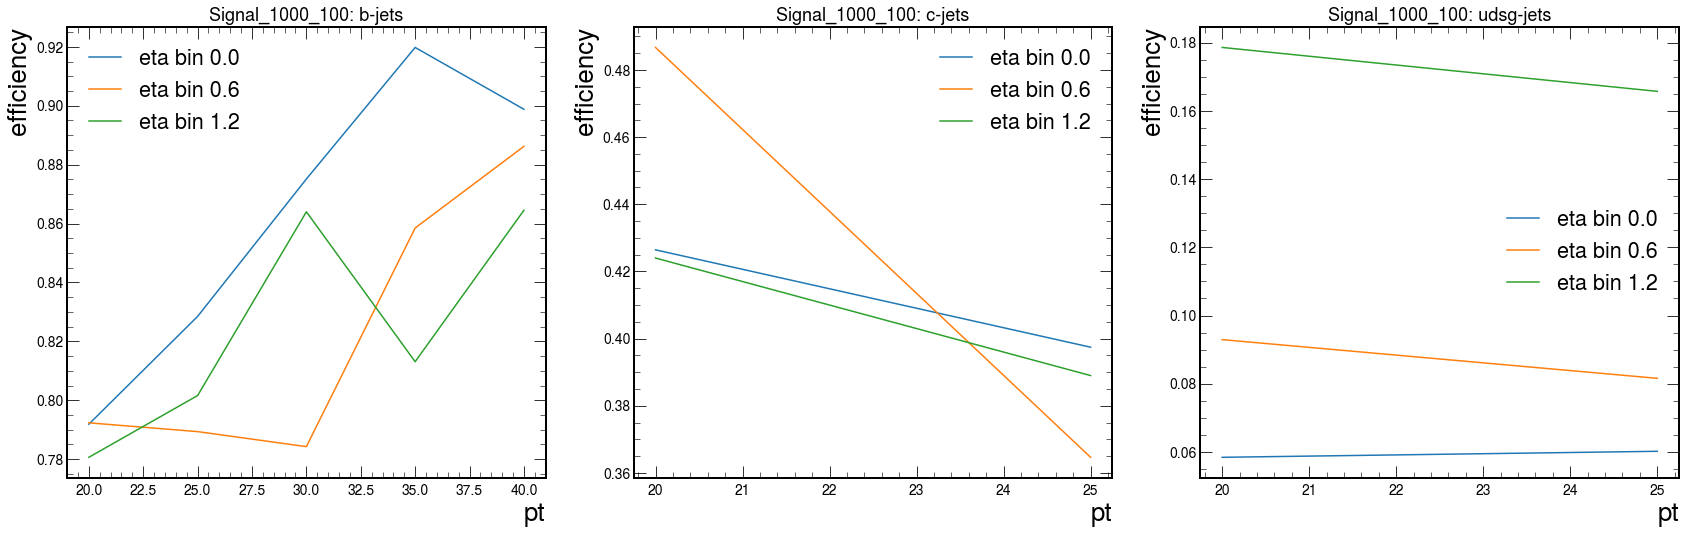

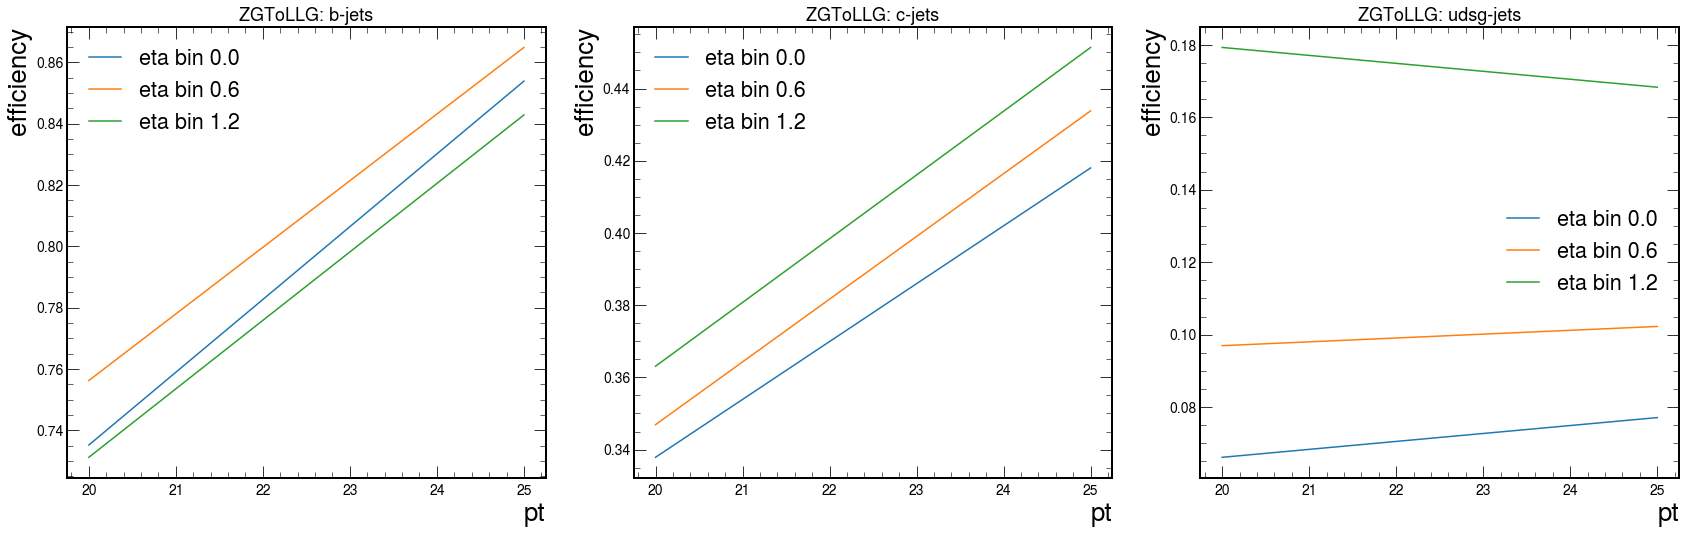

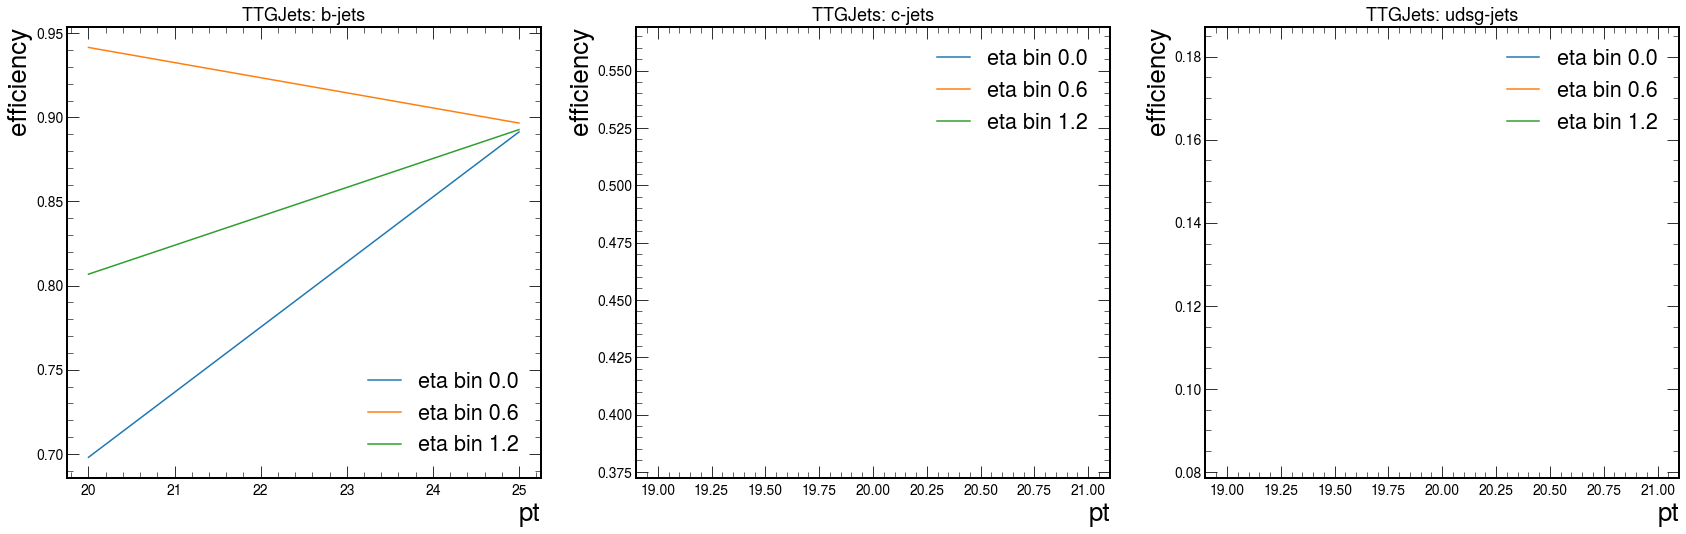

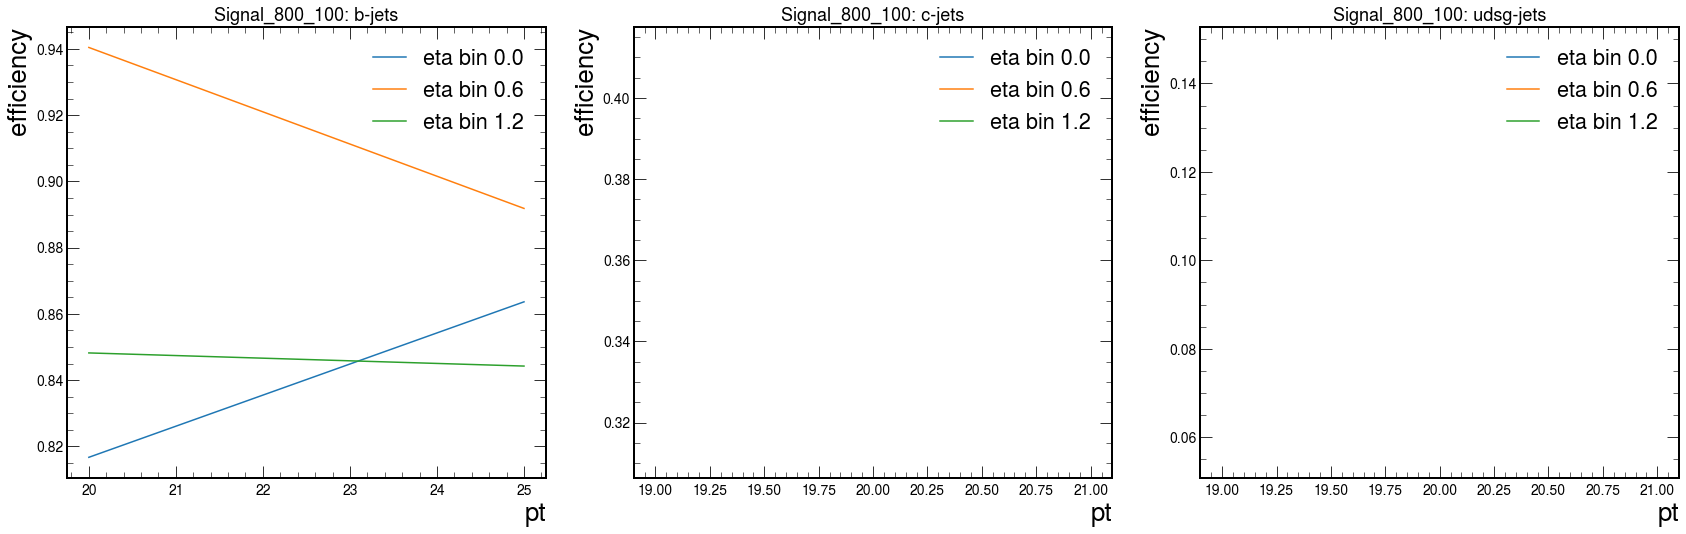

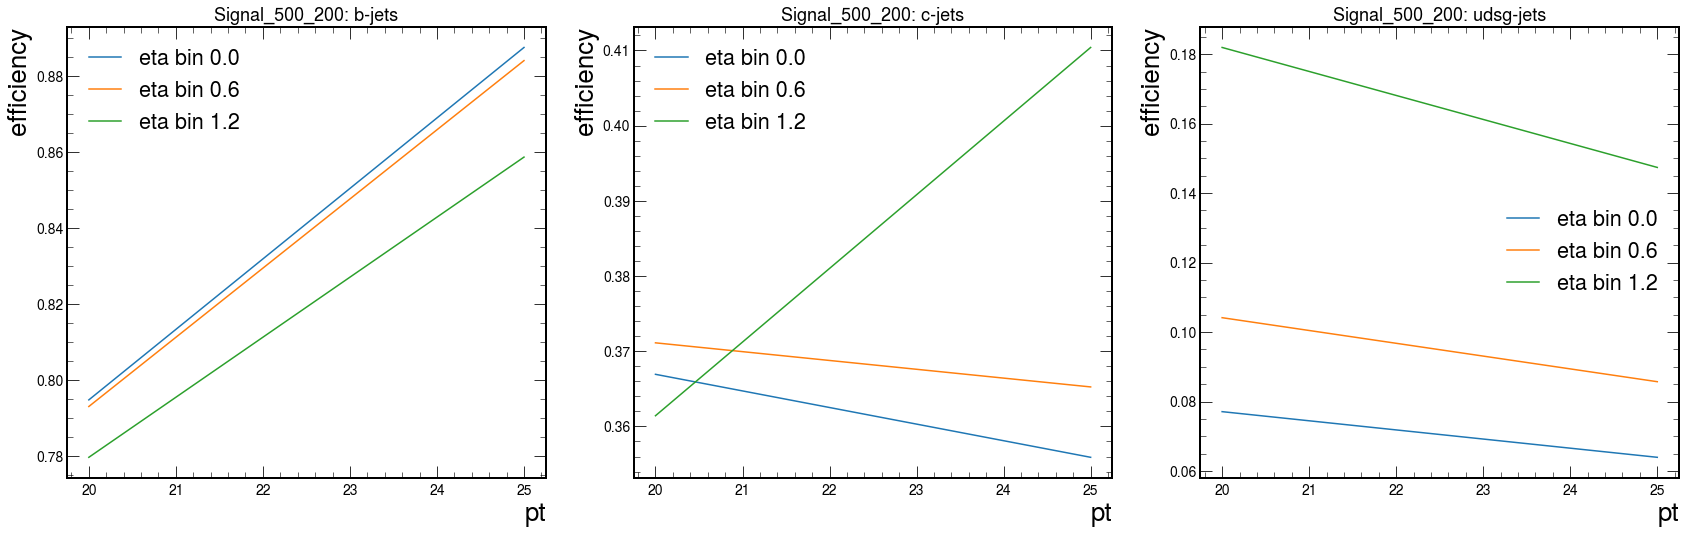

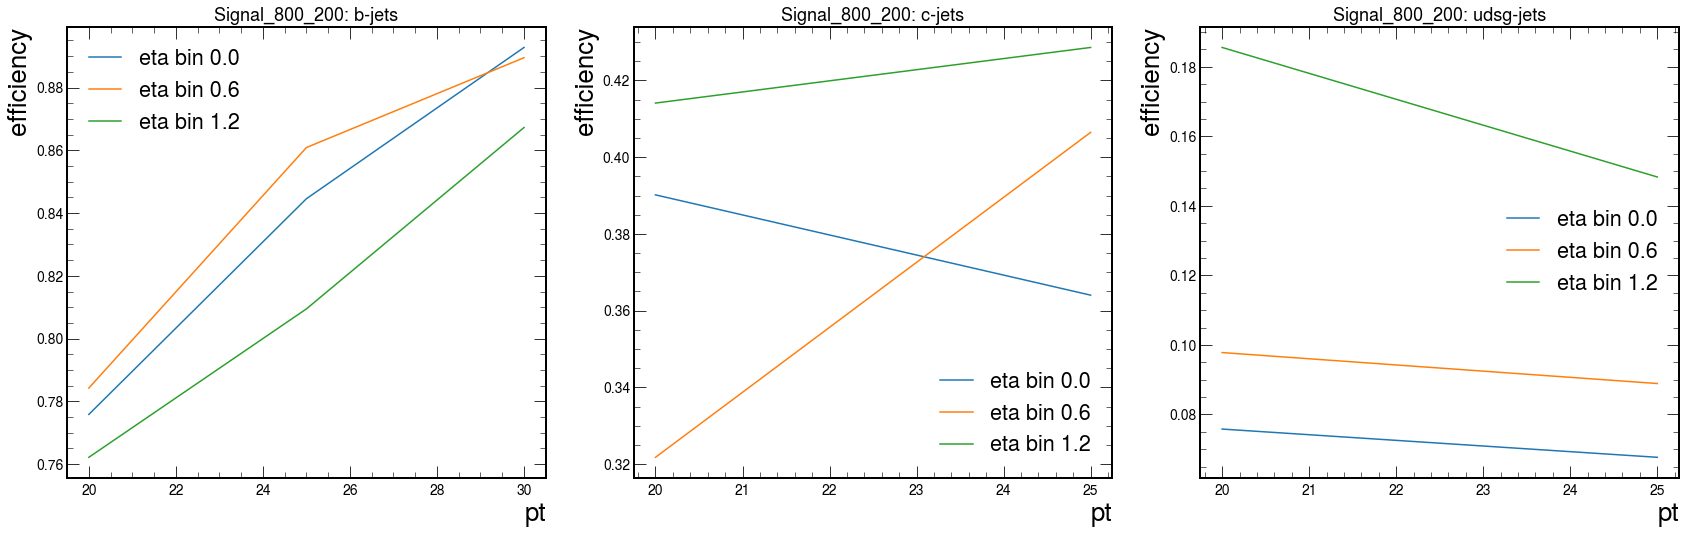

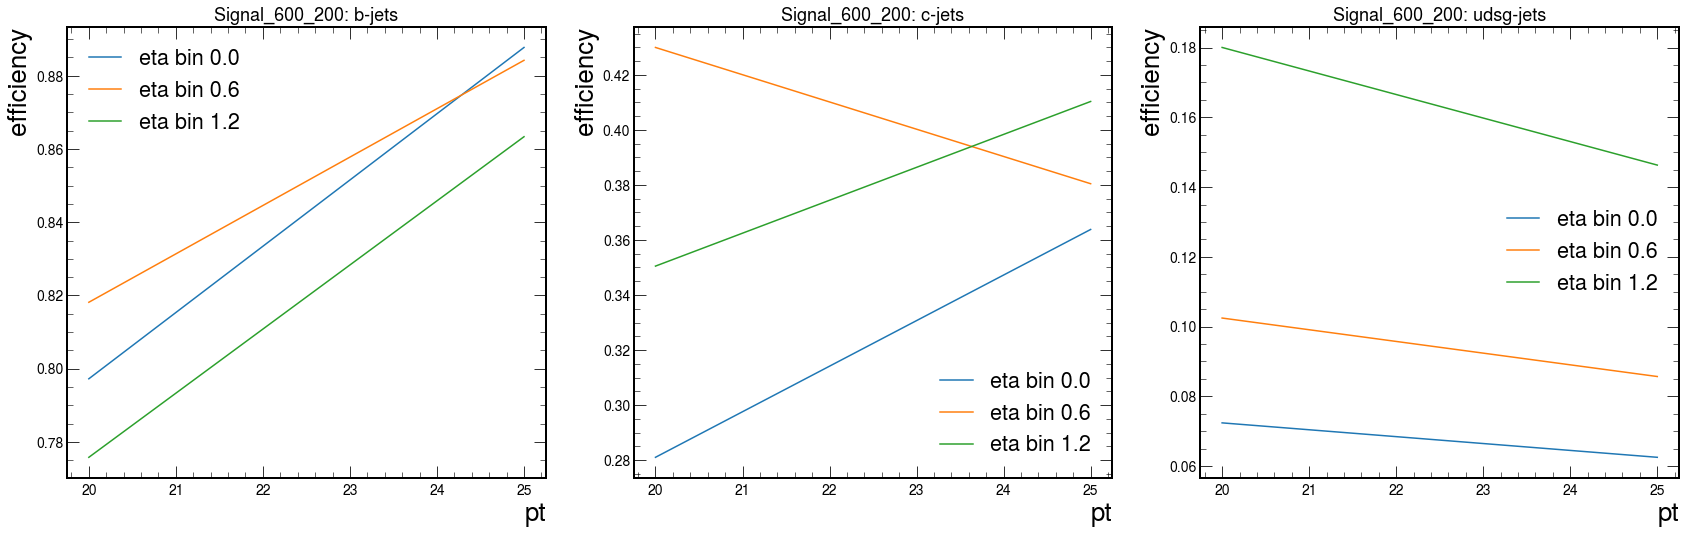

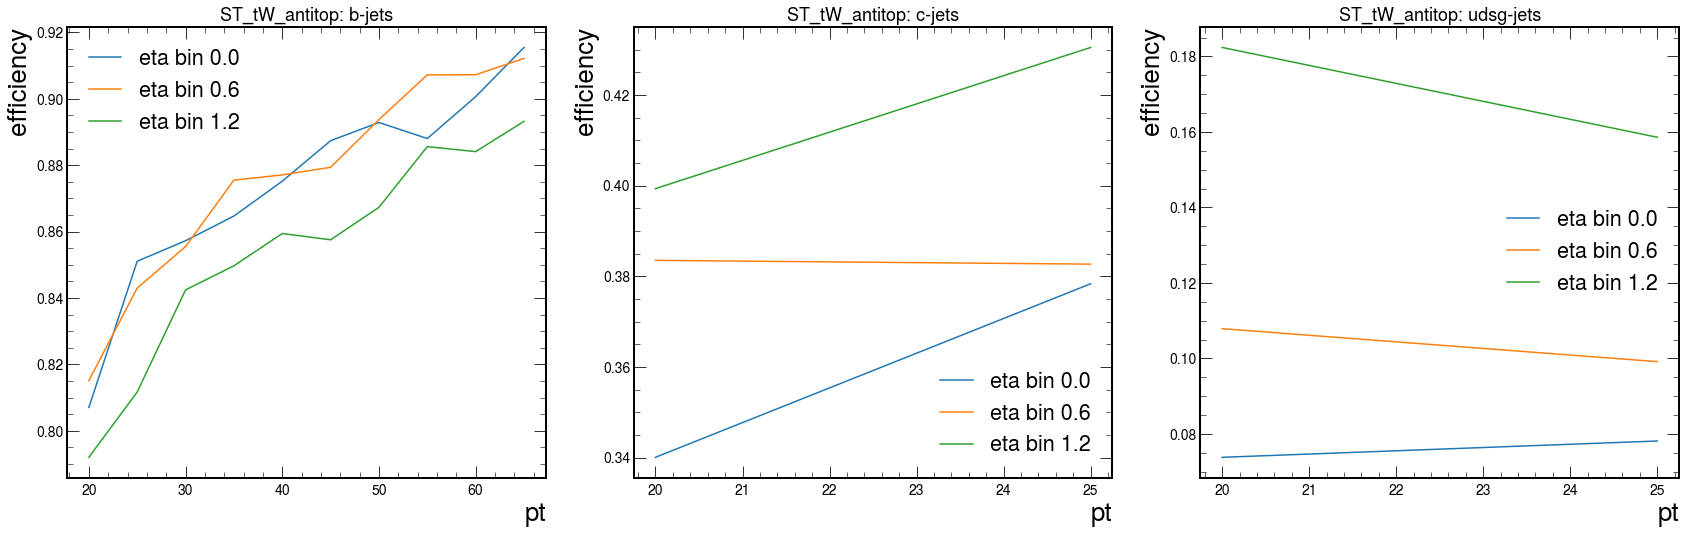

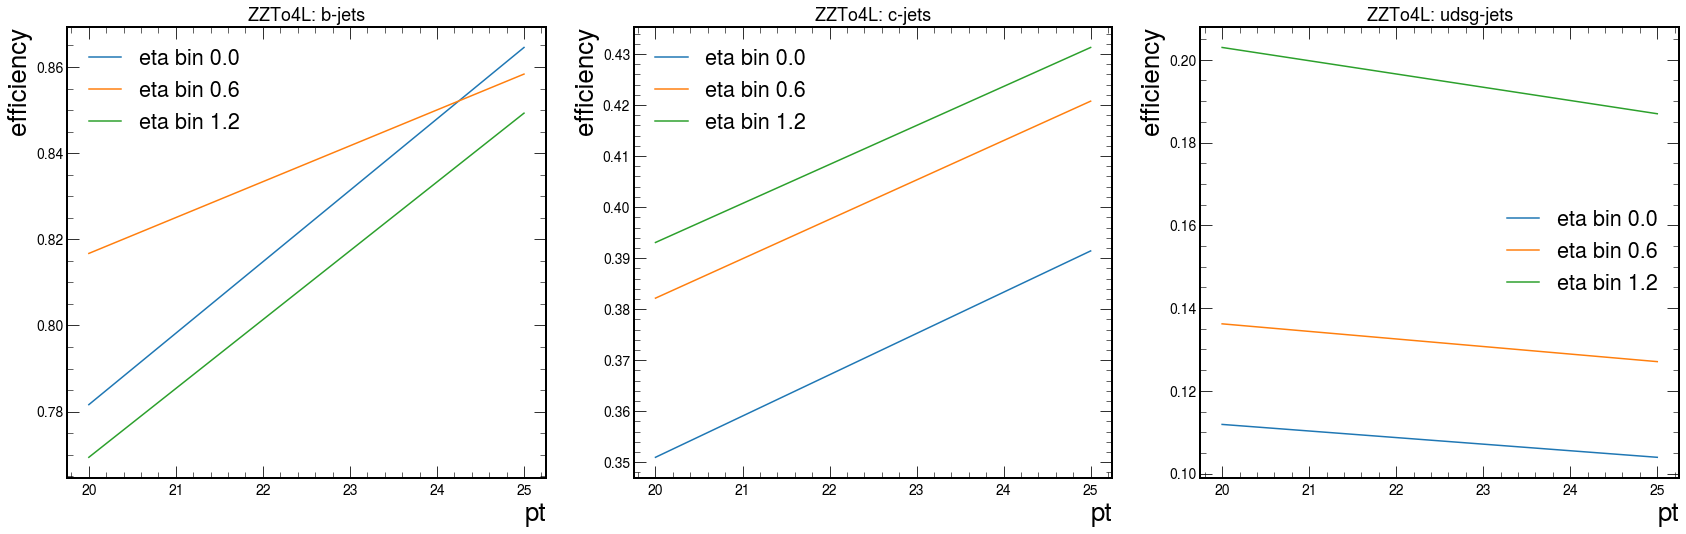

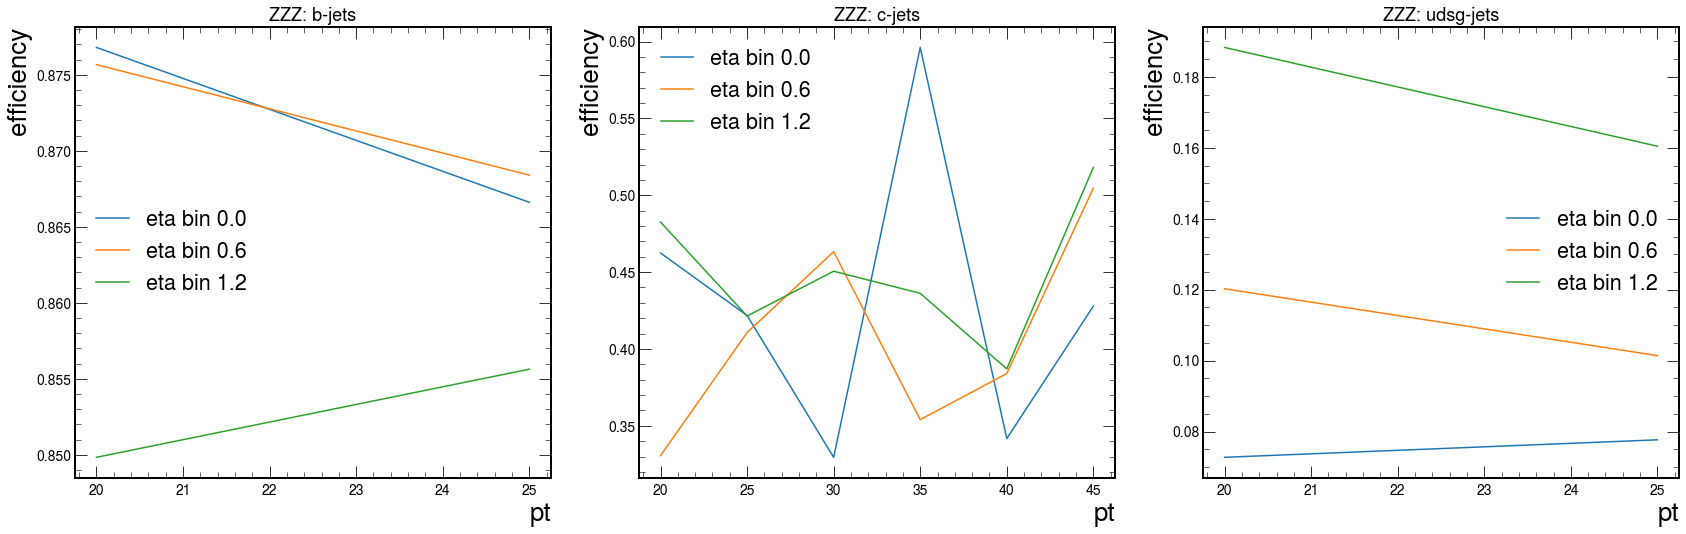

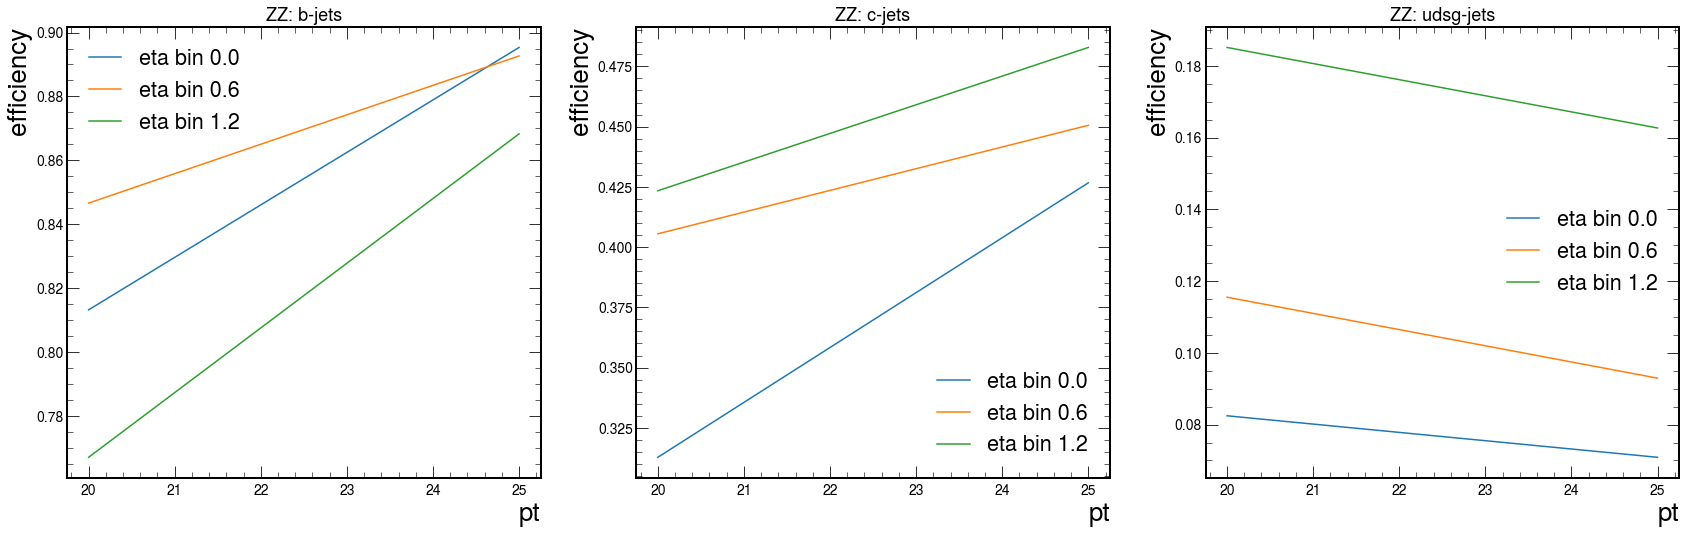

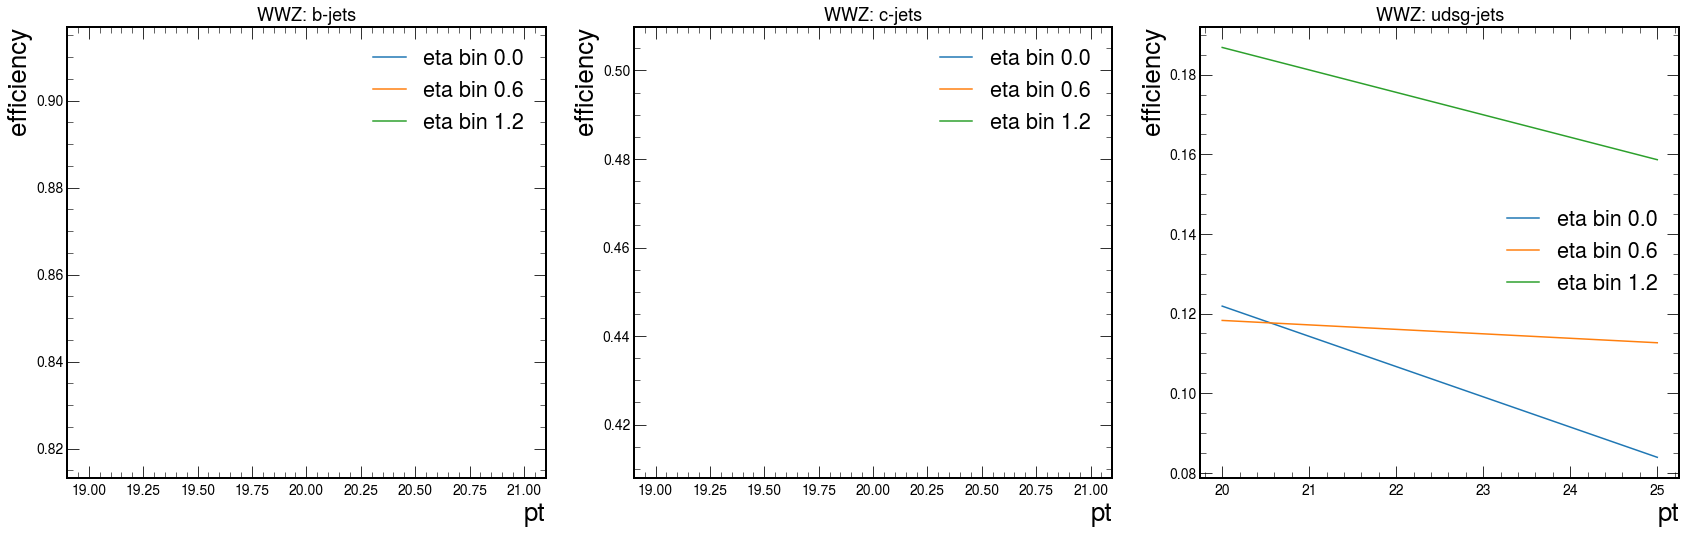

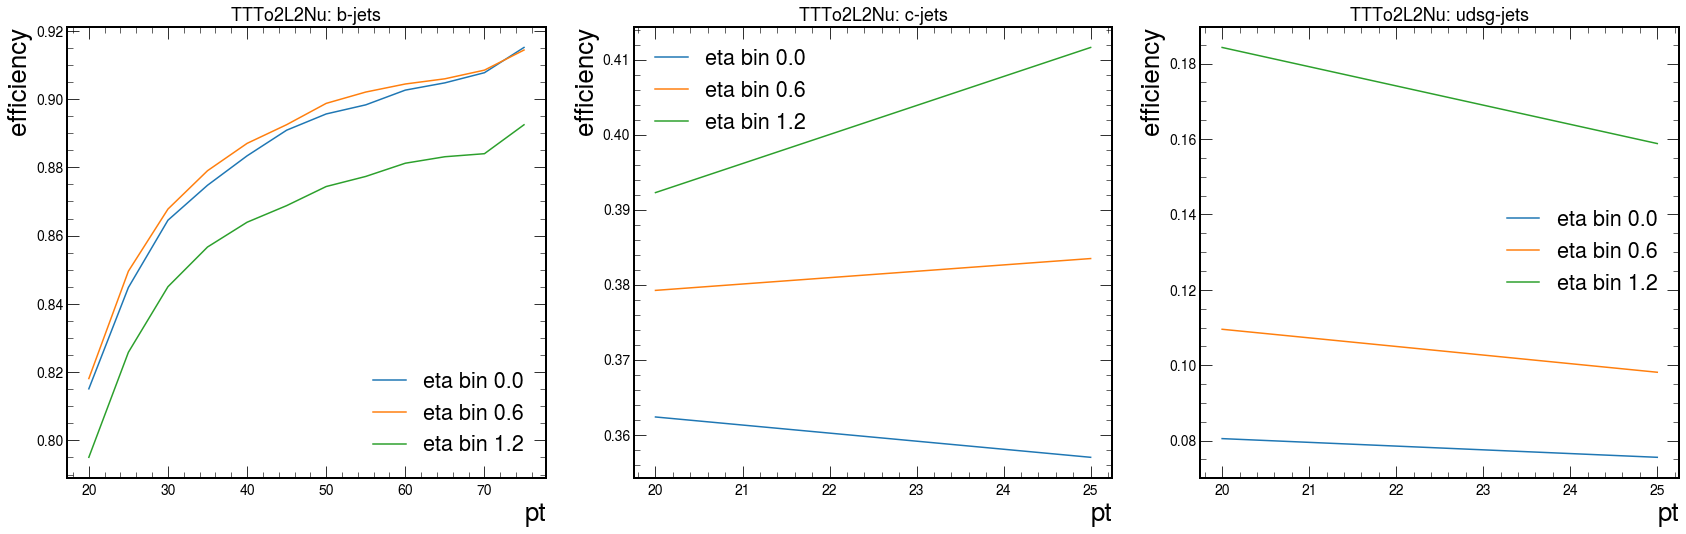

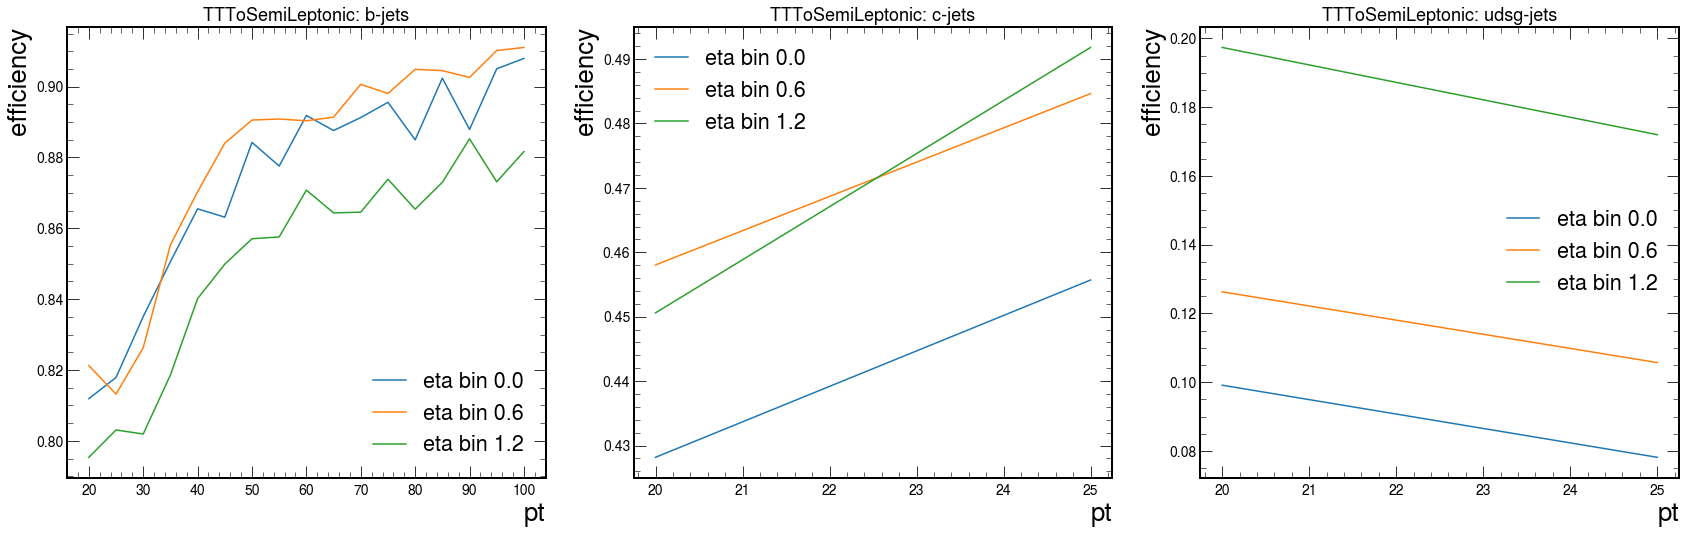

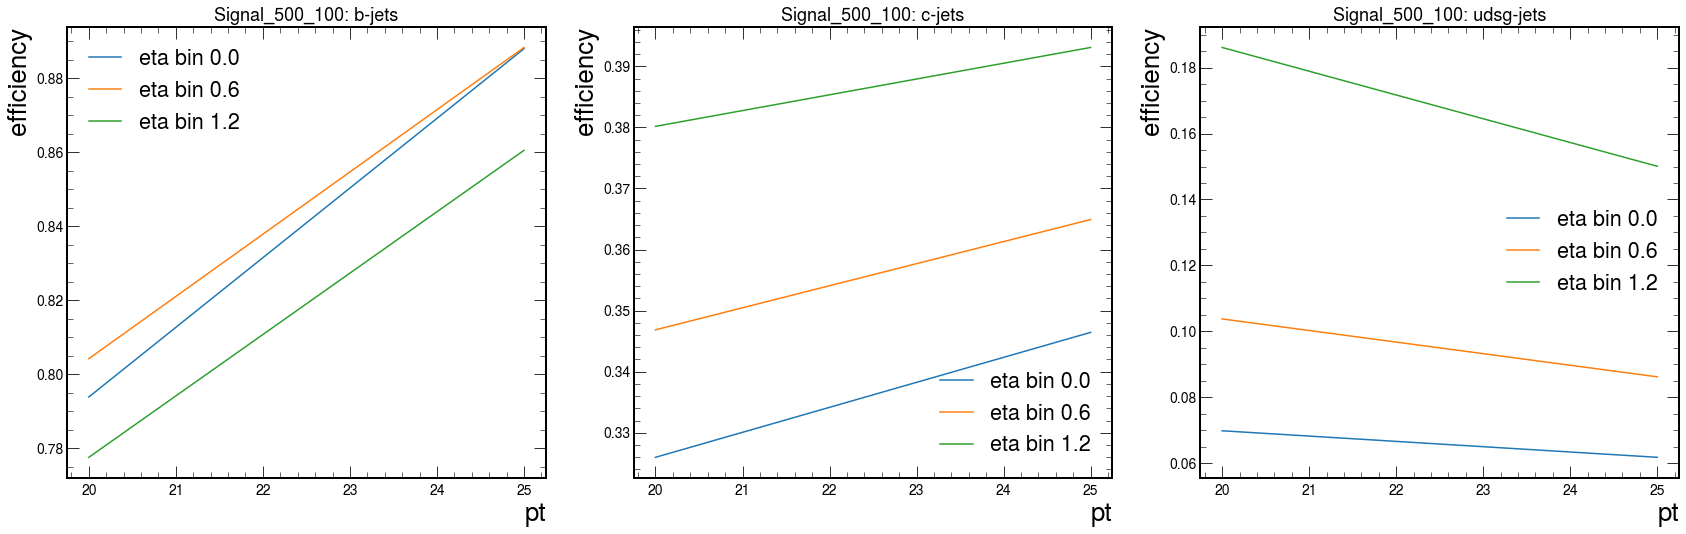

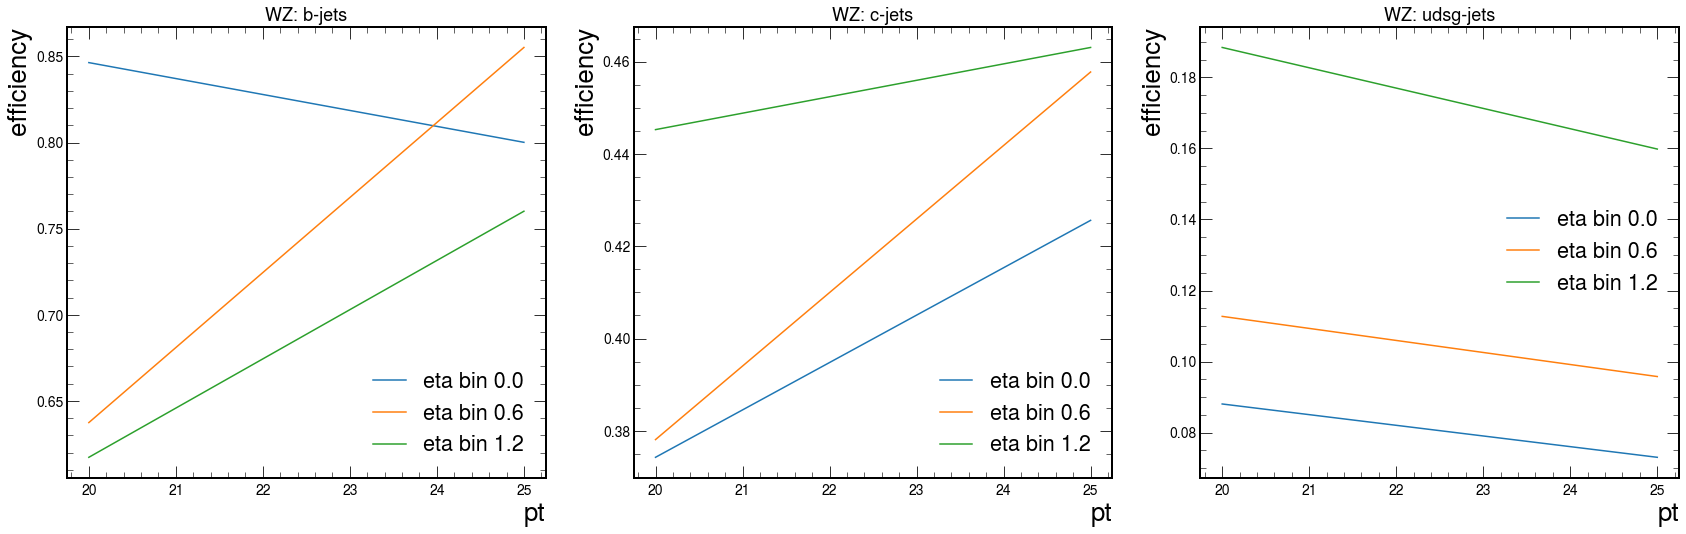

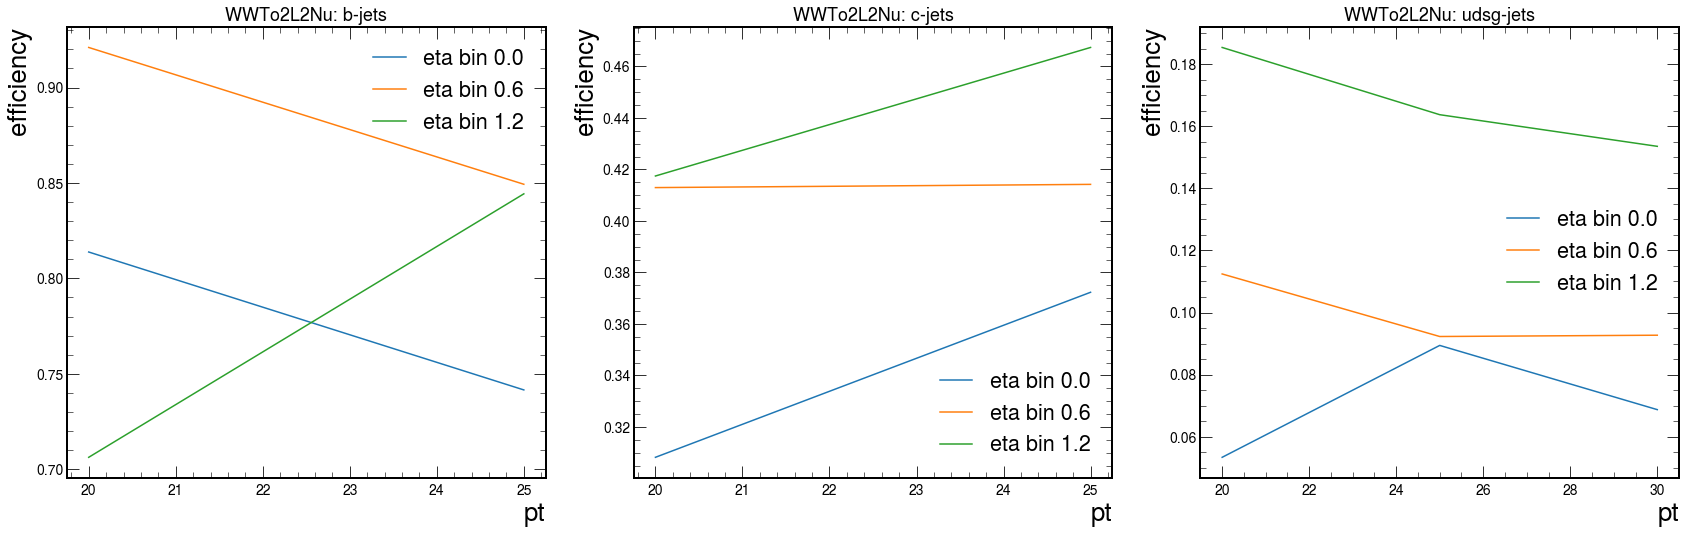

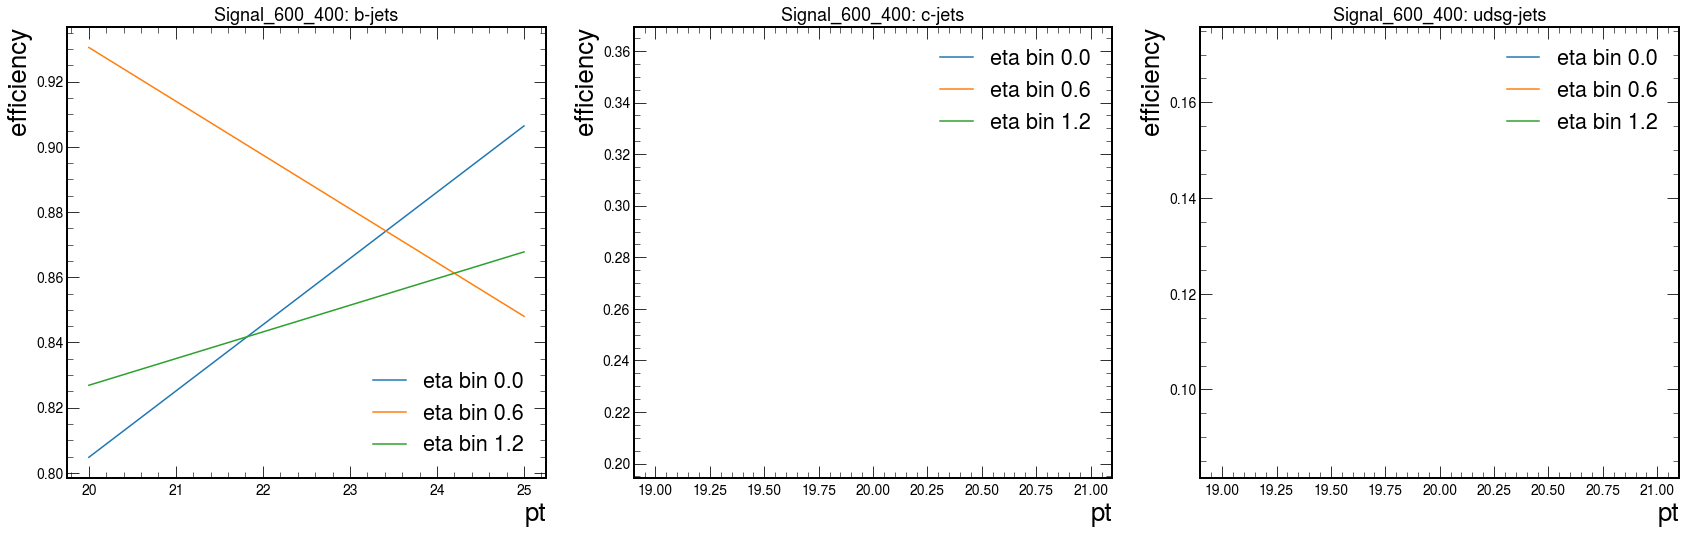

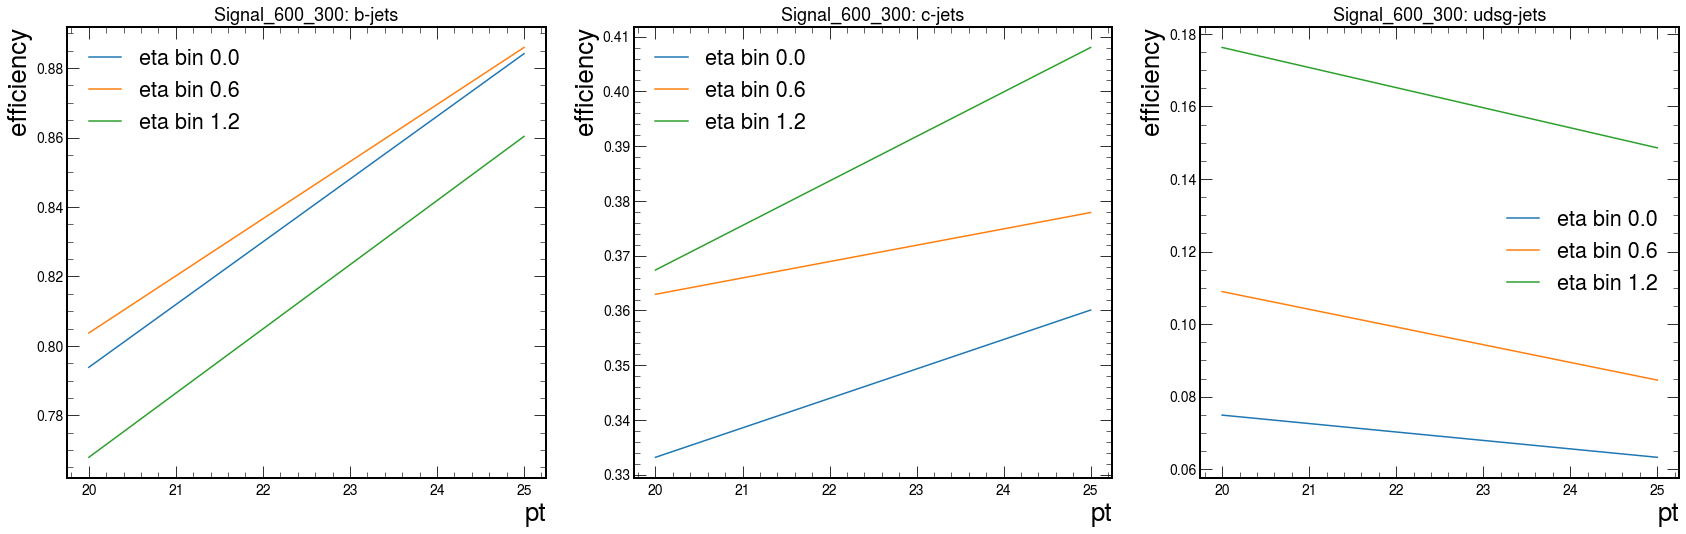

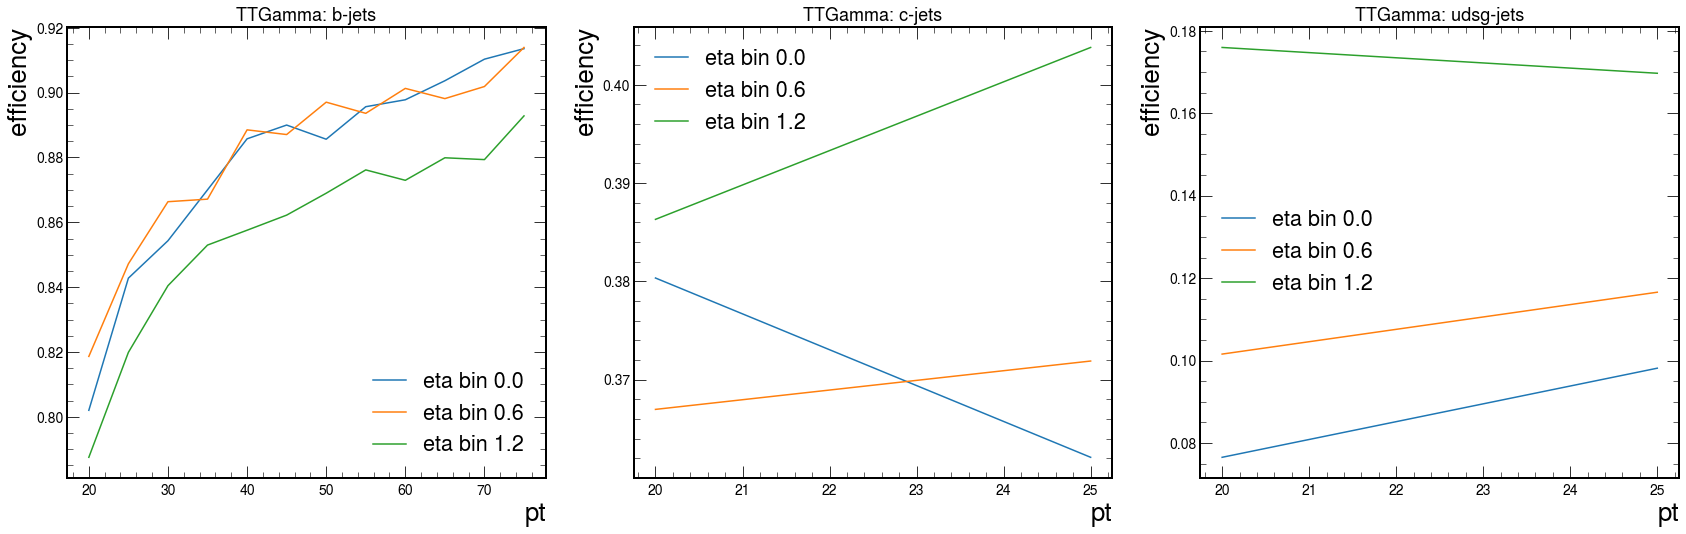

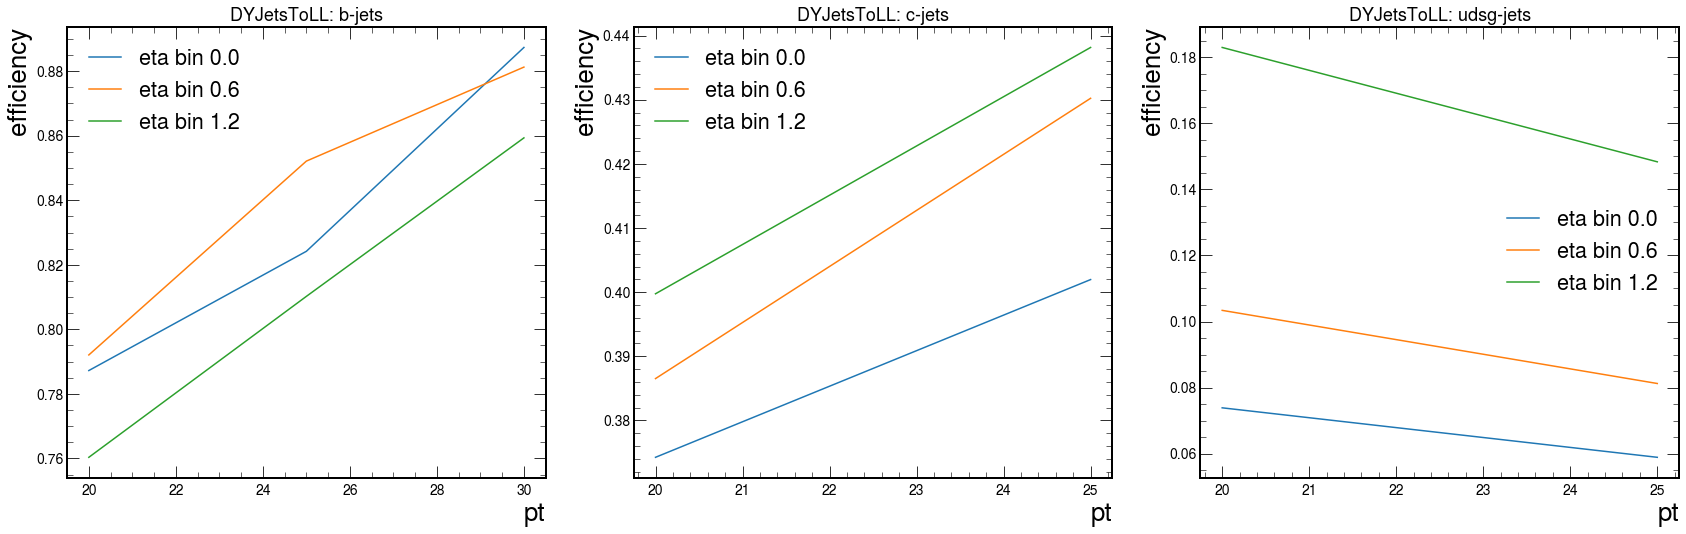

In [5]:
if os.path.isdir('../output/2017') is False:
    os.makedirs('../output/2017')

for dataset_name, eff_map in eff_maps.items():
    plot_fpath = os.path.join('../output/2017', f'{dataset_name}_effetabin_{algo}-{working_point}.png')
    fig = plt.figure(figsize=(24,8))
    for i, hf in enumerate(eff_map.keys()):
        dt = eff_map.get(hf)
        eta_min = np.array([d.get('eta_min') for d in dt])
        pt_min = np.array([d.get('pt_min') for d in dt])
        eff = np.array([d.get('eff') for d in dt])

        shape = (int(pt_min.size/3), 3)
        eta_min = eta_min.reshape(shape)[0]
        pt_min = pt_min.reshape(shape)[:,0]
        eff = eff.reshape(shape)

        ax = fig.add_subplot(1,3,i+1)
        for i, eta in enumerate(eta_min):
            ax.plot(pt_min, eff[:,i], label=f'eta bin {eta}')

        ax.set_title(f'{dataset_name}: {hf}-jets', fontsize=18)
        ax.set_xlabel('pt')
        ax.set_ylabel('efficiency')
        ax.legend()

    fig.tight_layout()
    plt.savefig(plot_fpath, facecolor='white', dpi=200)
    plt.show()